# Data analysis for _Distributed quantum sensing in a continuous-variable entangled network_

This notebook accompanies the paper [X. Guo, C. R. Breum, J. Borregaard, S. Izumi, M. V. Larsen, T. Gehring, M. Christandl, J. S. Neergaard-Nielsen & U. L. Andersen, _Distributed quantum sensing in a continuous-variable entangled network_, Nature Physics (2019)](https://doi.org/10.1038/s41567-019-0743-x). 
It demonstrates how to get from the phase calibration data and the raw oscilloscope trace measurements to the main results of the study, presented in Figure 3 of the paper.

To run the notebook, the following data files must be present in the same folder:

* `distsens_phasecalibration.hdf5`
* `distsens_spectra.hdf5` and/or `distsens_raw.hdf5`

`distsens_raw.hdf5` contains the raw oscilloscope traces and is 7.7 GB large. The initial processing of these data consists of normalization among the four channels and computation of the averaged power spectral densities (across 2000 traces) along with their variances. It is possible to skip these steps and simply load the already processed spectra contained in `distsens_spectra.hdf5`.

Furthermore, the following Python packages are required:

* numpy
* scipy
* matplotlib
* h5py
* jupyter

The results obtained here are not completely identical to those presented in the paper. The analysis done here follows closely the analysis behind the results in the paper (described in detail in the Supplementary Material) but we have simplified some steps, such as the trace normalization and the determination of the noise levels, and have found tighter error bars. We note that these changes only improve on the results in the paper.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.linalg import block_diag
from scipy import signal
import h5py

## Phase calibration

The purpose of the phase calibration is to determine how large phase shifts are induced on the probe light for given settings of the half-waveplates (manually set and read off by rotation mounts). The data consists of two sets of measurements: `phasecal_sq` for the squeezed (P) quadrature and `phasecal_asq` for the anti-squeezed (X) quadrature. Each set consists of an array of shape (4,5,40): 4 channels x 5 half-waveplate settings x 40 phase shift measurements.

In [23]:
phase_file = h5py.File('distsens_phasecalibration.hdf5', 'r')
hwp = phase_file['HWPsettings'][()]
phasecal_sq = phase_file['sq_phases'][()]
phasecal_asq = phase_file['asq_phases'][()]

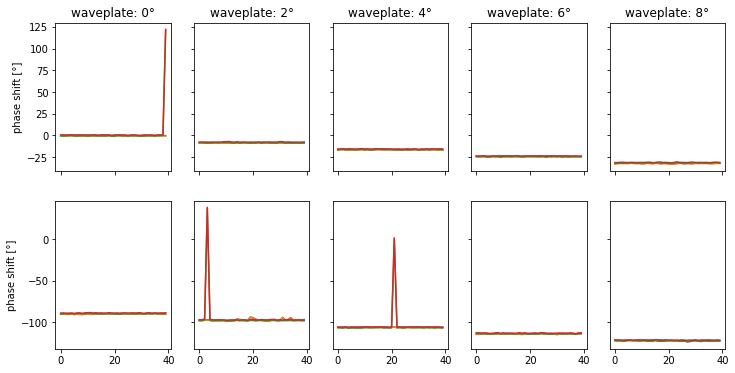

In [24]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey='row', figsize=(12,6))
for i in range(5):
    axs[0, i].plot(phasecal_sq[:,i].T)
    axs[1, i].plot(phasecal_asq[:,i].T)
    axs[0, i].set_title('waveplate: {:.0f}°'.format(hwp[i]))
axs[0, 0].set_ylabel('phase shift [°]')
axs[1, 0].set_ylabel('phase shift [°]');

Remove obvious outliers (accidental errors) and replot:

In [25]:
def outliers_to_nan(data, threshold=10):
    d = np.abs(data - np.median(data))
    data[d > threshold] = np.nan
    return data

for i in range(4):
    for j in range(5):
        phasecal_sq[i,j] = outliers_to_nan(phasecal_sq[i,j])
        phasecal_asq[i,j] = outliers_to_nan(phasecal_asq[i,j])

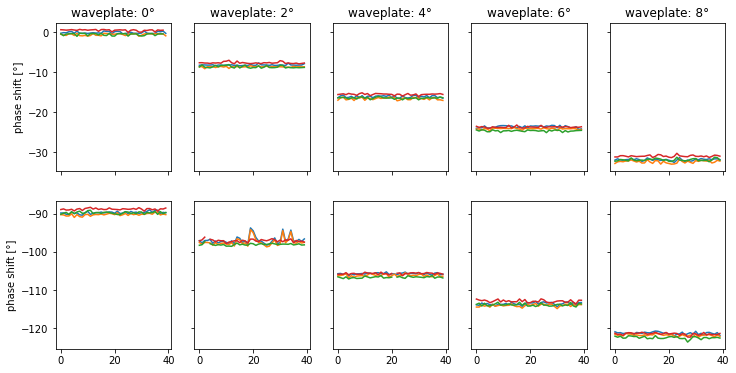

In [26]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey='row', figsize=(12,6))
for i in range(5):
    axs[0, i].plot(phasecal_sq[:,i].T)
    axs[1, i].plot(phasecal_asq[:,i].T)
    axs[0, i].set_title('waveplate: {:.0f}°'.format(hwp[i]))
axs[0, 0].set_ylabel('phase shift [°]')
axs[1, 0].set_ylabel('phase shift [°]');

Calculate mean and standard deviation of the average phase shifts of the four channels:

In [27]:
p_sq = np.mean(np.nanmean(phasecal_sq, axis=2), axis=0)
p_sq_std = 1/4 * np.sqrt(np.sum(np.nanstd(phasecal_sq, axis=2)**2, axis=0))

p_asq = np.mean(np.nanmean(phasecal_asq, axis=2), axis=0)
p_asq_std = 1/4 * np.sqrt(np.sum(np.nanstd(phasecal_asq, axis=2)**2, axis=0))

Get calibration - linear fit through the phase shifts:

In [28]:
fun_lin = lambda x, k, b: k * x + b
phases_fit_sq, phases_cov_sq = curve_fit(fun_lin, hwp, p_sq, [-4, 0], p_sq_std)
phases_fit_asq, phases_cov_asq = curve_fit(fun_lin, hwp, p_asq, [-4, -90], p_asq_std)

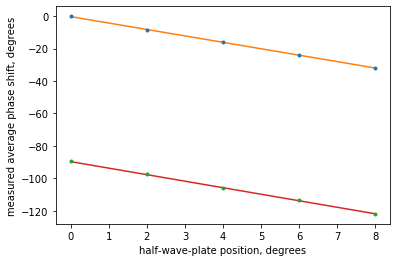

In [29]:
plt.errorbar(hwp, p_sq, p_sq_std, fmt='.')
plt.plot(hwp, fun_lin(hwp, *phases_fit_sq))
plt.errorbar(hwp, p_asq, p_asq_std, fmt='.')
plt.plot(hwp, fun_lin(hwp, *phases_fit_asq))
plt.xlabel('half-wave-plate position, degrees')
plt.ylabel('measured average phase shift, degrees');

Half-waveplate positions used in actual measurements, converted to phase shifts (with a change of sign to make them positive - purely for aesthetics):

In [30]:
hwp_sq = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])
hwp_asq = np.array([0, 2, 4])

phases_sq = -fun_lin(hwp_sq, *phases_fit_sq)
phases_asq = -fun_lin(hwp_asq, *phases_fit_asq)

phases = np.r_[phases_sq, phases_asq]
phases_rad = phases * np.pi / 180

In [31]:
phases_sq_std = np.sqrt(hwp_sq**2 * phases_cov_sq[0,0] + phases_cov_sq[1,1] + 
                        2 * hwp_sq * phases_cov_sq[0,1])
phases_asq_std = np.sqrt(hwp_asq**2 * phases_cov_asq[0,0] + phases_cov_asq[1,1] + 
                         2 * hwp_asq * phases_cov_asq[0,1])
phases_std = np.r_[phases_sq_std, phases_asq_std]
phases_std_rad = phases_std * np.pi / 180

The uncertainties on the calibrated phase shifts are so small and of similar size that we do not need to take them into account in the following (although we could, using e.g. the `scipy.odr` module to do fitting to data with errors in both x and y variables):

In [32]:
txt = 'HWP setting {:.0f}° -> {:.2f}° ± {:.2f}°'
for i in range(12):
    print(txt.format(np.r_[hwp_sq, hwp_asq][i], phases[i], phases_std[i]))

HWP setting 0° -> 0.25° ± 0.09°
HWP setting 1° -> 4.21° ± 0.07°
HWP setting 2° -> 8.18° ± 0.06°
HWP setting 3° -> 12.14° ± 0.05°
HWP setting 4° -> 16.10° ± 0.05°
HWP setting 5° -> 20.06° ± 0.06°
HWP setting 6° -> 24.02° ± 0.07°
HWP setting 7° -> 27.99° ± 0.08°
HWP setting 8° -> 31.95° ± 0.10°
HWP setting 0° -> 89.70° ± 0.21°
HWP setting 2° -> 97.74° ± 0.15°
HWP setting 4° -> 105.78° ± 0.12°


## Get power spectral densities

Here are two options for getting the power spectral densities for each of the phase settings for each of the measurement series (corresponding to one point in Figure 3 in the paper):

1. Load the already processed spectra from the `distsens_spectra.hdf5` file.
2. Re-generate all the spectra from the raw oscilloscope data in `distsens_raw.hdf5`. This will take a few minutes and requires several GB of memory.

You only need to run one of the following two cells.

### Load spectra

Simply load the preprocessed spectra.

Directory structure of `distsens_spectra.hdf5`:

```
- frequencies [shape: (5001,)]
- entangled
  - average
    - power1 [shape: (12, 5001)]
    - power2
    - power3
    - power4
    - power5
  - variance
    - power1
    - ...
- entangled_singlechannels
  - average
    - power1 [shape: (12, 4, 5001)]
    - power2
    - power3
    - power4
    - power5
  - variance
    - power1
    - ...
- separable
  - average
    - power1 [shape: (12, 5001)]
    - power2
    - power3
    - power4
  - variance
    - power1
    - ...
```
  

In [33]:
# load pre-generated spectra

psd_file = h5py.File('distsens_spectra.hdf5', 'r')

f = psd_file['frequencies'][()]
psd_ent = [p[()] for p in psd_file['entangled/average'].values()]
psd_ent_var = [p[()] for p in psd_file['entangled/variance'].values()]
psd_ent_singles = [p[()] for p in psd_file['entangled_singlechannels/average'].values()]
psd_ent_singles_var = [p[()] for p in psd_file['entangled_singlechannels/variance'].values()]
psd_sep = [p[()] for p in psd_file['separable/average'].values()]
psd_sep_var = [p[()] for p in psd_file['separable/variance'].values()]

### Generate spectra

Generate spectra (PSDs) and variances of spectra from oscilloscope data. The data contained in `distsens_raw.hdf5` are the raw integer (unscaled) data obtained from the oscilloscope, only repackaged into an HDF5 container. The directory structure is the following:

```
- entangled
  - power1
    - shotnoise
      - phase1
        - C1 [shape: (2000, 10002)]
        - C2
        - C3
        - C4
    - squeezed
      - phase1
        - C1 [shape: (2000, 10002)]
        - C2
        - C3
        - C4
      - phase2
        - C1
        - ...
      - ...
      - phase9
        - C1
        - C2
        - C3
        - C4
    - antisqueezed
      - phase1
        - C1 [shape: (2000, 10002)]
        - C2
        - C3
        - C4
      - phase2
        - C1
        - ...
      - phase3
        - C1
        - C2
        - C3
        - C4
  - power2
    - [identical to power1]
  - power3
    - [identical to power1]
  - power4
    - [identical to power1]
  - power5
    - [identical to power1]
- separable
  - power1
    - shotnoise
      - phase1
        - C1 [shape: (2000, 10002)]
    - squeezed
      - phase1
        - C1 [shape: (2000, 10002)]
      - phase2
        - C1
      - ...
      - phase9
        - C1
    - antisqueezed
      - phase1
        - C1 [shape: (2000, 10002)]
      - phase2
        - C1
      - phase3
        - C1
  - power2
    - [identical to power1]
  - power3
    - [identical to power1]
  - power4
    - [identical to power1]
```

The steps performed are marked in the code below and are, in outline:

1. Define parameters: We use all 2000 traces of each measurement (but this could be reduced for e.g. speed reasons), the oscilloscope sample rate was 50 MS/s, and we use 10000 of the samples instead of the full 10002 in order to get nicer frequencies in the Fourier transform.
2. Open the data file and prepare empty lists to hold the spectra.
3. Define a function to build the power spectral densities (PSD) using the [periodogram](https://en.wikipedia.org/wiki/Periodogram) approach, imported from the [SciPy signal processing package](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html). We average the 2000 PSDs and calculate the variance of the average values by dividing the PSD variance with the number of traces.
4. Process the measurements done with the entangled setup.
  1. Load the vacuum (shotnoise) data and do a periodogram to get the frequency range and average PSDs of the four homodyne channels. Calculate the average noise of each channel in the 2.5--3.5 MHz range and use this in the following to normalize the four channels to each other AND to the shotnoise level.
  1. Load the squeezing data (P-measurements at various phase shifts) and normalize each channel to the shotnoise level. Combine the four channels by taking the mean to get $\hat{P}_\mathrm{avg}$. Do the same for the antisqueezing (X) measurements.
  1. Compute the PSDs (with their variance) for both P and X measurements, both for the individual channels and for the combined.
5. Do the same for the measurements done with the separable setup. This time there's only a single channel, though.


In [43]:
# re-generate spectra

# STEP 1
number_traces = 2000  # how many traces to include for each dataset - max 2000
slice_traces = slice(number_traces)
samplerate = 50e6
samples = 10000

# STEP 2
data_file = h5py.File('distsens_raw.hdf5', 'r')

psd_ent_singles = []
psd_ent_singles_var = []
psd_ent = []
psd_ent_var = []
psd_sep = []
psd_sep_var = []

# STEP 3
def buildPSD(traces):
    _, spectra = signal.periodogram(traces, fs=samplerate, nfft=samples, axis=-1)
    avgspectra = spectra.mean(-2)
    varspectra = spectra.var(-2) / spectra.shape[-2]
    return avgspectra, varspectra

# STEP 4
for data in data_file['entangled'].values():
    print('Processing ', data.name)
    print(' - calculating homodyne detector normalization')
    
    # STEP 4A
    sn_traces = np.array([ch[slice_traces] for ch in 
                          data['shotnoise/phase1'].values()])

    f, sn_spec = signal.periodogram(sn_traces, 
                                    fs=samplerate, nfft=samples, axis=-1)
    f = f / 1e6  # change to MHz
    sn_spec = sn_spec.mean(1)  # average over 2000 traces
    
    # normalize to the average shotnoise voltage of each channel 
    # in the 2.5-3.5 MHz band (indices 500-700 in the spectrum)
    scalefactors = np.sqrt(1 / sn_spec[:, 500:700].mean(1))

    print(' - reading data')
    
    # STEP 4B
    sq_traces = np.array([[ch[slice_traces] for ch in ph.values()] 
                          for ph in data['squeezed'].values()])
    sq_traces = sq_traces * scalefactors.reshape((1, 4, 1, 1))
    # take the average of the four homodyne detector signals
    sq_traces_combined = sq_traces.mean(1)

    asq_traces = np.array([[ch[slice_traces] for ch in ph.values()] 
                          for ph in data['antisqueezed'].values()])
    asq_traces = asq_traces * scalefactors.reshape((1, 4, 1, 1))
    # take the average of the four homodyne detector signals
    asq_traces_combined = asq_traces.mean(1)

    print(' - calculating PSD spectra')
    
    # STEP 4C
    psd = np.array([buildPSD(t) for t in sq_traces] + 
                   [buildPSD(t) for t in asq_traces])
    psd_ent_singles.append(psd[:,0])
    psd_ent_singles_var.append(psd[:,1])
    psd = np.array([buildPSD(t) for t in sq_traces_combined] + 
                   [buildPSD(t) for t in asq_traces_combined])
    psd_ent.append(psd[:,0])
    psd_ent_var.append(psd[:,1])

# STEP 5
for data in data_file['separable'].values():
    print('Processing ', data.name)
    print(' - calculating homodyne detector normalization')
    sn_trace = np.array(data['shotnoise/phase1/C1'])[slice_traces]

    _, sn_spec = signal.periodogram(sn_trace, 
                                    fs=samplerate, nfft=samples, axis=-1)
    sn_spec = sn_spec.mean(0)  
    scalefactor = np.sqrt(1 / sn_spec[500:700].mean())

    print(' - reading data')
    sq_traces = np.array([ph['C1'][slice_traces] for ph in 
                          data['squeezed'].values()])
    sq_traces = sq_traces * scalefactor

    asq_traces = np.array([ph['C1'][slice_traces] for ph in 
                           data['antisqueezed'].values()])
    asq_traces = asq_traces * scalefactor

    print(' - calculating PSD spectra')
    psd = np.array([buildPSD(t) for t in sq_traces] + 
                   [buildPSD(t) for t in asq_traces])
    psd_sep.append(psd[:,0])
    psd_sep_var.append(psd[:,1])

Processing  /entangled/power1
 - calculating homodyne detector normalization
 - reading data
 - calculating PSD spectra
Processing  /entangled/power2
 - calculating homodyne detector normalization
 - reading data
 - calculating PSD spectra
Processing  /entangled/power3
 - calculating homodyne detector normalization
 - reading data
 - calculating PSD spectra
Processing  /entangled/power4
 - calculating homodyne detector normalization
 - reading data
 - calculating PSD spectra
Processing  /entangled/power5
 - calculating homodyne detector normalization
 - reading data
 - calculating PSD spectra
Processing  /separable/power1
 - calculating homodyne detector normalization
 - reading data
 - calculating PSD spectra
Processing  /separable/power2
 - calculating homodyne detector normalization
 - reading data
 - calculating PSD spectra
Processing  /separable/power3
 - calculating homodyne detector normalization
 - reading data
 - calculating PSD spectra
Processing  /separable/power4
 - calcula

### Re-create figure 2 in the paper

Figure 2 in the paper shows the PSDs in a narrow region around the modulation frequency, 3 MHz, for the four individual channels and for their combination. In the paper the traces are shown for the first 6 phase shift settings, showing a gradually increasing signal peak. This number can be modified below.

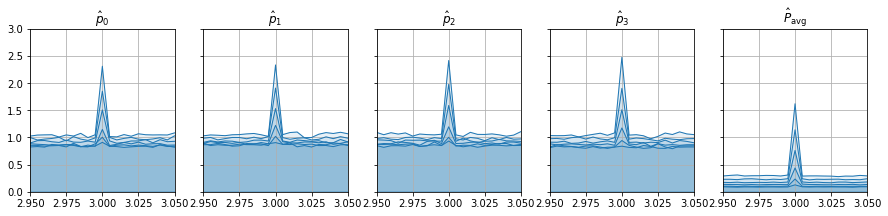

In [34]:
fig, axs = plt.subplots(1, 5, figsize=(15, 3), sharey=True)

number_phases = 6  # how many phases (starting from 0°) to include in plot

for i in range(5):
    if i < 4:
        spectra = psd_ent_singles[2][:number_phases,i]
        label = r'$\hat{{p}}_{}$'.format(i)
    elif i == 4:
        spectra = psd_ent[2][:number_phases]
        label = r'$\hat{P}_\mathrm{avg}$'
        
    for s in spectra:
        axs[i].fill_between(f, s, color='C0', alpha=.1)
        axs[i].plot(f, s, color='C0', lw=1)
    axs[i].set_xlim(2.95, 3.05)
    axs[i].set_ylim(0, 3)
    axs[i].grid(True)
    axs[i].set_title(label)
    

## Calculate sensitivities from PSDs

To obtain the main result, we first extract the signal and noise levels from the various spectra, then use those numbers to calculate the sensitivities and photon numbers.

### Extract signal and noise levels from PSDs

From the narrow regions of the spectra shown above, extract the peak amplitude and noise levels (in units of amplitude, as per the description in our Supplementary Material).

1. Define array indices to extract the peak (a single point at 3 MHz) and the noise in the surrounding region between 2.95 and 3.05 MHz.
2. Define a function that takes a set of PSDs and PSD variances and outputs the signal, the noise and their standard deviations, following eq. (54) in SM. Allow for the different shot noise levels of the separable (snl = 1) and entangled (snl = 1/4 due to the averaging of four channels) measurements.
3. Define the models for the $\phi_\mathrm{avg}$-dependence of the signal and noise. These are given in eq. (44) in SM, although due to the normalization of the oscilloscope traces to the shot noise, $V_{sn}$ is already incorporated into $V_s$ and $V_n$.
4. Prepare empty lists to hold the signal, noise, and uncertainties for each phase shift setting for each power setting for each of the entangled and separable setups. Also prepare lists to hold the parameters and parameter covariances output from the curve fitting.
5. Extract the signal, noise and their uncertainties from all the entangled PSDs. Use SciPy's `optimize.curve_fit` function to fit the data to the two models for signal and noise, including in the fits the statistical uncertainties on these data.
6. Repeat for the separable PSDs.

In [35]:
# STEP 1

# boolean indexing array selecting the frequency components neighbouring 3.00 MHz
noise_indices = ((2.95 <= f) & (f <= 3.05) & (f != 3))
peak_index = (f == 3)

# STEP 2
def signal_noise_error(psd, psd_var, snl=1):
    noisepower = psd[:, noise_indices].mean(1) / snl
    peaks = psd[:, peak_index].flatten() / snl
    
    noisepower_var = psd_var[:, noise_indices].mean(1) / snl**2
    peaks_var = psd_var[:, peak_index].flatten() / snl**2
    
    signalpower = (peaks - noisepower)
    noise = np.sqrt(noisepower)
    sig = np.sqrt(signalpower)
    
    noise_std = np.sqrt(noisepower_var / (4 * noisepower))
    sig_std = np.sqrt(peaks_var / (4 * peaks) + 
                      noisepower_var / (4 * noisepower))
    
    return sig, noise, sig_std, noise_std

# STEP 3
def model_signal(phi, amp, theta): 
    return amp * np.abs(np.sin(phi + theta))

def model_noise(phi, vsq, vasq, theta): 
    return np.sqrt(vsq**2 * np.cos(phi + theta)**2 +
                   vasq**2 * np.sin(phi + theta)**2)

# STEP 4
signal_ent = []
signal_ent_std = []
signal_ent_pfit = []
signal_ent_pcov = []
noise_ent = []
noise_ent_std = []
noise_ent_pfit = []
noise_ent_pcov = []
signal_sep = []
signal_sep_std = []
signal_sep_pfit = []
signal_sep_pcov = []
noise_sep = []
noise_sep_std = []
noise_sep_pfit = []
noise_sep_pcov = []

# STEP 5
for psd, psd_var in zip(psd_ent, psd_ent_var):
    sig, noise, sig_std, noise_std = signal_noise_error(psd, psd_var, snl=1/4)
    signal_ent.append(sig)
    noise_ent.append(noise)
    signal_ent_std.append(sig_std)
    noise_ent_std.append(noise_std)
    
    signal_pfit, signal_pcov = curve_fit(model_signal, phases_rad, sig, [1, 0],
                                         sig_std, True)
    noise_pfit, noise_pcov = curve_fit(model_noise, phases_rad, noise, [.2, 1, 0],
                                       noise_std, True)
    signal_ent_pfit.append(signal_pfit)
    signal_ent_pcov.append(signal_pcov)
    noise_ent_pfit.append(noise_pfit)
    noise_ent_pcov.append(noise_pcov)

# STEP 6
for psd, psd_var in zip(psd_sep, psd_sep_var):
    sig, noise, sig_std, noise_std = signal_noise_error(psd, psd_var, snl=1)
    signal_sep.append(sig)
    noise_sep.append(noise)
    signal_sep_std.append(sig_std)
    noise_sep_std.append(noise_std)
    
    signal_pfit, signal_pcov = curve_fit(model_signal, phases_rad, sig, [1, 0],
                                         sig_std, True)
    noise_pfit, noise_pcov = curve_fit(model_noise, phases_rad, noise, [.2, 1, 0],
                                       noise_std, True)
    signal_sep_pfit.append(signal_pfit)
    signal_sep_pcov.append(signal_pcov)
    noise_sep_pfit.append(noise_pfit)
    noise_sep_pcov.append(noise_pcov)

### For all measurement series, create figure like Fig. 10 in Supplement

Plot the signal values (left) and noise values (right) along with the fits. Nine pairs of plots; five for entangled setups at the different powers, four for the separable.

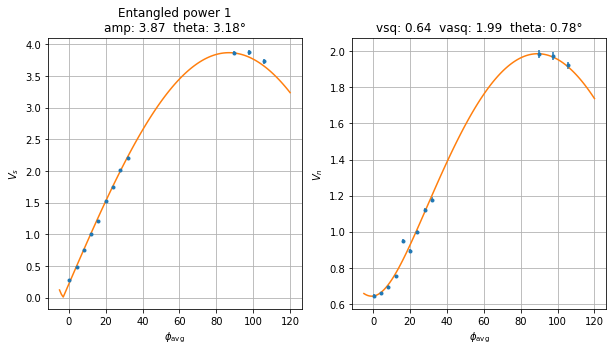

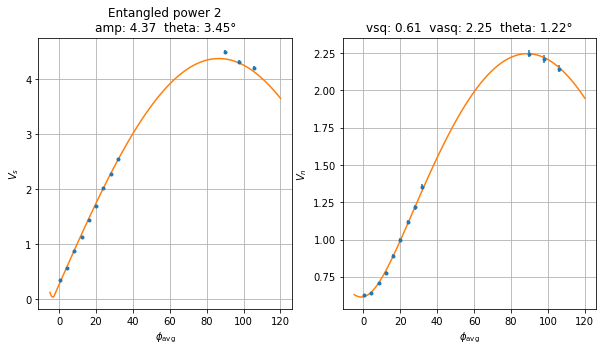

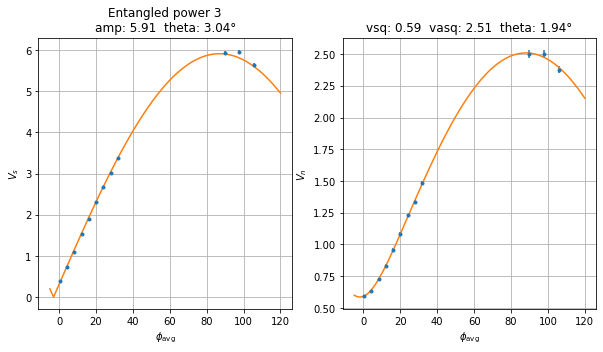

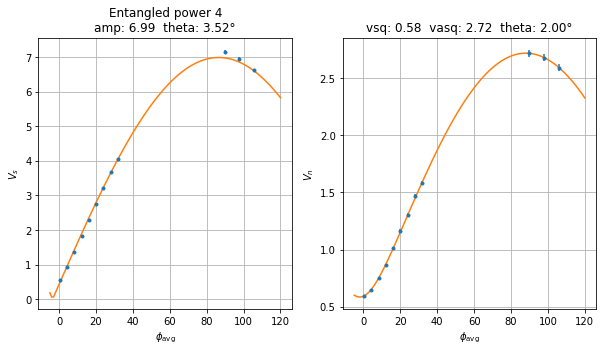

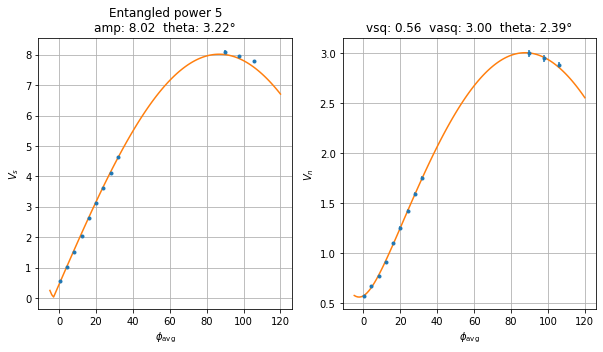

In [46]:
ph = np.linspace(-5, 120, 126)
ph_rad = ph * np.pi / 180

for i in range(len(signal_ent)):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].errorbar(phases, signal_ent[i], signal_ent_std[i], phases_std, '.')
    axs[0].plot(ph, model_signal(ph_rad, *signal_ent_pfit[i]))
    axs[0].grid()
    axs[0].set_xlabel(r'$\phi_\mathrm{avg}$')
    axs[0].set_ylabel(r'$V_s$')
    axs[0].set_title('Entangled power {}\namp: {:.2f}  theta: {:.2f}°'.format(
        i + 1, signal_ent_pfit[i][0], signal_ent_pfit[i][1] * 180/np.pi))
    
    axs[1].errorbar(phases, noise_ent[i], noise_ent_std[i], phases_std, '.')
    axs[1].plot(ph, model_noise(ph_rad, *noise_ent_pfit[i]))
    axs[1].grid()
    axs[1].set_xlabel(r'$\phi_\mathrm{avg}$')
    axs[1].set_ylabel(r'$V_n$')
    axs[1].set_title('vsq: {:.2f}  vasq: {:.2f}  theta: {:.2f}°'.format(
        noise_ent_pfit[i][0], noise_ent_pfit[i][1], noise_ent_pfit[i][2] * 180/np.pi))

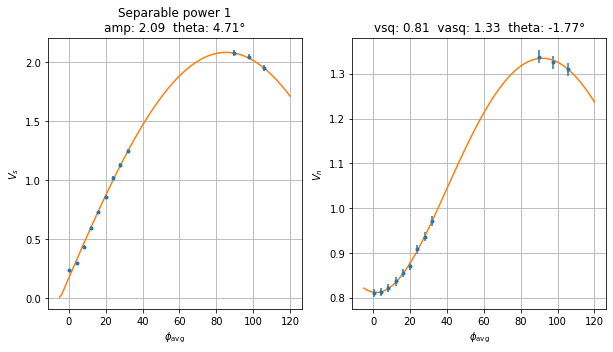

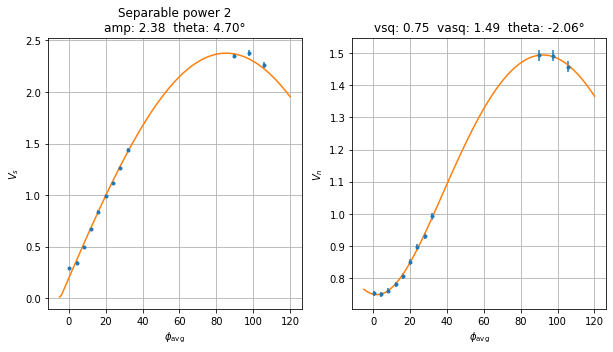

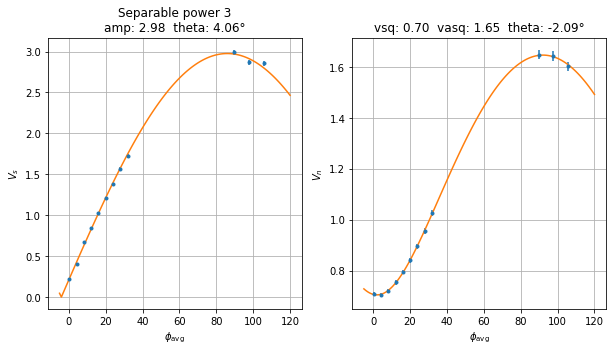

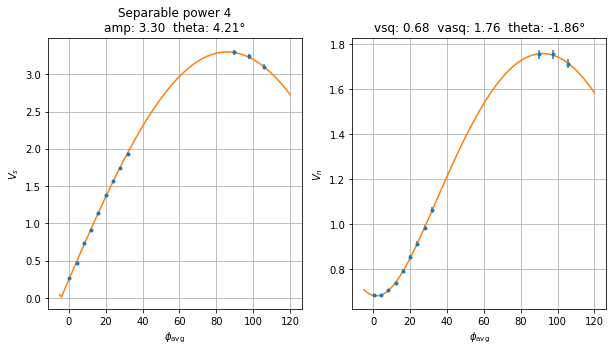

In [47]:
for i in range(len(signal_sep)):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].errorbar(phases, signal_sep[i], signal_sep_std[i], phases_std, '.')
    axs[0].plot(ph, model_signal(ph_rad, *signal_sep_pfit[i]))
    axs[0].grid()
    axs[0].set_xlabel(r'$\phi_\mathrm{avg}$')
    axs[0].set_ylabel(r'$V_s$')
    axs[0].set_title('Separable power {}\namp: {:.2f}  theta: {:.2f}°'.format(
        i + 1, signal_sep_pfit[i][0], signal_sep_pfit[i][1] * 180/np.pi))
    
    axs[1].errorbar(phases, noise_sep[i], noise_sep_std[i], phases_std, '.')
    axs[1].plot(ph, model_noise(ph_rad, *noise_sep_pfit[i]))
    axs[1].grid()
    axs[1].set_xlabel(r'$\phi_\mathrm{avg}$')
    axs[1].set_ylabel(r'$V_n$')
    axs[1].set_title('vsq: {:.2f}  vasq: {:.2f}  theta: {:.2f}°'.format(
        noise_sep_pfit[i][0], noise_sep_pfit[i][1], noise_sep_pfit[i][2] * 180/np.pi))

### Calculate sensitivities and photon numbers

We determine the sensitivities for each of the nine measurements using the optimal parameters and parameter covariances from the fits. They are evaluated at $\phi_\mathrm{avg} = 0$. To estimate the photon numbers, we use the noise variances measured at our 0° phase shift settings of $P$ and $X$ (for squeezing photons) and the maximum signal amplitude, that is, the one measured at 0° phase shift of $X$ (for coherent photons).

1. Define a function to calculate the sensitivity from eq. (56) in SM based on the signal and noise models and fitted parameter estimates. The function also calculates the uncertainty on the sensitivity using linear error propagation with the full covariance matrices of the fitted parameters.

2. Define functions to estimate the photon numbers $N_{sqz}$ and $N_{coh}$ and their uncertainties from the data using eqs. (58-61) in SM. Includes a parameter to provide the number of modes, cf. the difference between eqs. (58-59) and (60-61).

3. Calculate sensitivities and photon numbers for the entangled and separable measurements and put in lists. For the separable measurements, the sensitivity is divided by $\sqrt{4}$ to account for the fact that we only measure a single sample, not four.

In [94]:
# STEP 1
def sensitivity(signal_p, noise_p, signal_pcov, noise_pcov):
    A = model_noise(0, *noise_p)
    B = signal_p[0] * np.cos(signal_p[1])
    sens = A / B
    
    jac_A = np.array([noise_p[0] * np.cos(noise_p[2])**2 / A ,
                      noise_p[1] * np.sin(noise_p[2])**2 / A,
                      ((noise_p[1]**2 - noise_p[0]**2) * 
                       np.cos(noise_p[2]) * np.sin(noise_p[2]) / A)])
    var_A = jac_A @ noise_pcov @ jac_A
    var_A = jac_A @ np.diag(noise_pcov.diagonal()) @ jac_A
    
    jac_B = np.array([np.cos(signal_p[1]),
                      -signal_p[0] * np.sin(signal_p[1])])
    var_B = jac_B @ signal_pcov @ jac_B
    var_B = jac_B @ np.diag(signal_pcov.diagonal()) @ jac_B
    
    std = abs(sens) * np.sqrt(var_A / A**2 + var_B / B**2)
    
    return sens, std

# STEP 2
def photons_sq(noise, noise_std, modes):
    vsq = noise[0]
    vasq = noise[9]
    vsq_std = noise_std[0]
    vasq_std = noise_std[9]
    
    Nsq = 1/4 * (vsq**2 + vasq**2 - 2) / modes
    Nsq_std = np.sqrt(vsq**2 / 4 * vsq_std**2 + 
                      vasq**2 / 4 * vasq_std**2) / modes
        
    return Nsq, Nsq_std

def photons_coh(sig, sig_std, modes):
    amp = sig[9]
    amp_std = sig_std[9]
    
    Ncoh = amp**2 / 4 / modes
    Ncoh_std = amp / 2 * amp_std / modes
    
    return Ncoh, Ncoh_std

# STEP 3
M = 4
N_ent = []
N_ent_std = []
mu_ent = []
sigma_ent = []
sigma_ent_std = []
N_sep = []
N_sep_std = []
mu_sep = []
sigma_sep = []
sigma_sep_std = []

for s, scov, n, ncov in zip(signal_ent_pfit, signal_ent_pcov,
                            noise_ent_pfit, noise_ent_pcov):    
    sens, std = sensitivity(s, n, scov, ncov)
    sigma_ent.append(sens)
    sigma_ent_std.append(std)

for s, scov, n, ncov in zip(signal_sep_pfit, signal_sep_pcov,
                            noise_sep_pfit, noise_sep_pcov):
    sens, std = sensitivity(s, n, scov, ncov)
    sigma_sep.append(sens / np.sqrt(M))
    sigma_sep_std.append(std / np.sqrt(M))

for s, sstd, n, nstd in zip(signal_ent, signal_ent_std,
                            noise_ent, noise_ent_std):
    Nsq, Nsq_std = photons_sq(n, nstd, M)
    Ncoh, Ncoh_std = photons_coh(s, sstd, M)
    
    N_ent.append(Nsq + Ncoh)
    N_ent_std.append(np.sqrt(Nsq_std**2 + Ncoh_std**2))
    mu_ent.append(Nsq / (Nsq + Ncoh))   
    
for s, sstd, n, nstd in zip(signal_sep, signal_sep_std,
                            noise_sep, noise_sep_std):
    Nsq, Nsq_std = photons_sq(n, nstd, 1)
    Ncoh, Ncoh_std = photons_coh(s, sstd, 1)
    
    N_sep.append(Nsq + Ncoh)
    N_sep_std.append(np.sqrt(Nsq_std**2 + Ncoh_std**2))
    mu_sep.append(Nsq / (Nsq + Ncoh))   

### Re-create Fig. 3 in the paper

Finally, we plot the sensitivities versus photon number and compare with theory, as in the main result in Figure 3 of the paper.

First, define the theoretical optimized sensitivities, eqs. (4-5) in the paper or (27, 31) in SM:

In [95]:
def sigma_ent_opt(M, N, eta):
    return (1 / (2 * M * N) * 
            np.sqrt((M * N * (1 - eta) + eta / 2 +
                     eta / 2 * np.sqrt(1 + 4 * M * N * (1 - eta))) /
                    (1 + eta / (M * N))))

def sigma_sep_opt(M, N, eta):
    return (1 / (2 * np.sqrt(M) * N) * 
            np.sqrt((N * (1 - eta) + eta / 2 +
                     eta / 2 * np.sqrt(1 + 4 * N * (1 - eta))) /
                    (1 + eta / (N))))

...and do the plot:

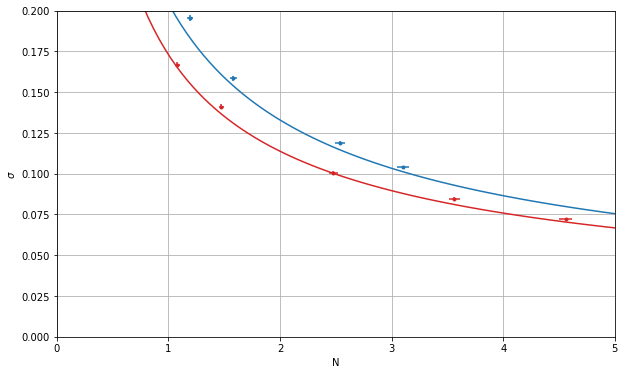

In [103]:
N = np.linspace(.01, 5, 100)

fig = plt.figure(figsize=(10, 6))
plt.plot(N, sigma_ent_opt(M, N, .735), color='C3')
plt.errorbar(N_ent, sigma_ent, sigma_ent_std, N_ent_std, fmt='.', color='C3')

plt.plot(N, sigma_sep_opt(M, N, .735), color='C0')
plt.errorbar(N_sep, sigma_sep, sigma_sep_std, N_sep_std, fmt='.', color='C0')

plt.ylim(0, .2)
plt.xlim(0, 5)
plt.grid()
plt.xlabel('N')
plt.ylabel(r'$\sigma$');